# Feedforward and Recurrent Neural Networks
## Application to Ground Vibration Test of an F-16 aircraft. Description of the benchmark: https://www.nonlinearbenchmark.org/benchmarks/f-16-gvt

### Course on Deep Learning for System Identification
### Authors: Dario Piga, Marco Forgione
### Lugano, March 7th, 2024

## Goal: estimate the dynamical behaviour of an F-16 aircraft due to vibrations

**- Inputs**: 
1. voltage measured at the output of the signal generator amplifier, acting as a reference input,
2. actual force provided by the shaker and measured by a impedance head at the excitation location.

**- Outputs:** acceleration signals measured:
1. at the excitation location ('Acceleration 1')
2. on the right wing next to the interface ('Acceleration 2')
3. on the payload next to the interface ('Acceleration 3')

# Exercise 1 (Feedforward NN):

- **Estimate a nonlinear model** describing the relation between the inputs and the three outputs.
- Since the two inputs are strongly correlated, you can use either both inputs in your model, or just one of them.
- Create three independent models, one for each output. Or alternatively, create one single model with 3 outputs.
- For the output $y_i$ (i=0,1,2), **consider as a model architecture a fully-connected feedforward Neural Network** taking past  measurements of the two inputs (up to time k) and  measurements of the $i$-th output (up to time k-1), and returning an estimate of the output at time k.
- **Test your results** in the dataset not used for training. Check the performance of your model both on 1-step ahead prediction and simulation. You can use the following metrics to assess the performance of your model:

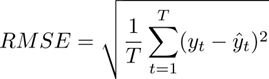

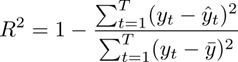

## Step 0: Data importing and normalization

Train and test datasets are saved in the GitHub folder *Dataset\F16*, both in a .mat and .csv  format.
- **Train dataset**: F16Data_SineSw_Level3
- **Test datasets**: F16Data_SineSw_Level4_Validation

For instance, you can read the csv file using the command ``pd.read_csv'' from pandas library (see cell below). 

From the available dataset, construct the regressor (containing past measurements of inputs and output). Alternatively, we have already prepared for you a subclass of the PyTorch class *Dataset*, called *F16DS*, which provides for you regressor x(k) and associated output y(k). In the *F16DS* class, the regressor is made by: the two inputs from time k up to time k-nb;  one signle output of interest from time k-1 up to time k-na. Hyper-parameters nb and na, as well as the output of interest, must be specified by the user.

See cells below to import the Database and use the dataLoader to extract element from the database. Data normalization is also performed. 

Feel free to run the cells below or write your own script to read and process the data. 

In [4]:
# F16 - data reading and normalizatiob
import os
import pandas as pd
import torch


folder = os.path.join('..', 'Datasets', 'F16') 
f_train_ds =  os.path.join(folder, 'F16Data_SineSw_Level3.csv')
f_test_ds = os.path.join(folder, 'F16Data_SineSw_Level4_Validation.csv')

# create dictionary with training and test dataset
dict_ds = {'train': [], 'test': [],}
dict_ds['train'] = pd.read_csv(f_train_ds) 
dict_ds['test'] = pd.read_csv(f_test_ds)

# data normalization
ds_mean = dict_ds['train'].mean() 
ds_std = dict_ds['train'].std()
dict_ds['train']  = (dict_ds['train'] - ds_mean)/ds_std
dict_ds['test']  = (dict_ds['test'] - ds_mean)/ds_std


In [5]:
# create custome DataSet
from torch.utils.data import Dataset, DataLoader
from dataset import F16DS

# 
ind_out = 0 # output index (0 or 1 or 2)
na = 5  # output lag
nb = 20 # input lag

# Create Dataset (trainign and test)
F16DS_train = F16DS(pd_file = dict_ds['train'], na = na, nb = nb, ind_out = ind_out)
F16DS_test = F16DS(pd_file = dict_ds['test'], na = na, nb = nb, ind_out = ind_out)

# access elements of the datasets. Example
idx = 10 # sample index
x, y = F16DS_train[idx]

print(f"Training: regressor at step {idx}: {x} \n")
print(f"Training: output at step {idx}: {y} \n")


Training: regressor at step 10: tensor([-4.0133e-03,  3.9508e-04,  1.0225e-03,  8.7239e-04,  4.1384e-03,
        -5.5150e-04, -8.1693e-04, -8.7056e-04, -4.4369e-03,  1.4034e-04,
         9.1528e-04,  6.8470e-04,  3.7040e-03, -8.2230e-04, -9.5640e-04,
        -8.1961e-04, -4.4101e-03,  2.2347e-04,  8.1070e-04,  3.7631e-04,
         3.6745e-03,  2.9666e-04,  4.7372e-04,  5.9176e-04,  3.5567e-04,
         2.9666e-04,  6.5077e-04,  3.5567e-04,  3.5567e-04,  2.9666e-04,
         2.9666e-04,  3.2617e-04,  1.7861e-04,  2.3763e-04,  2.9666e-04,
         3.5567e-04, -5.7473e-05,  1.7861e-04, -1.4601e-04,  2.0812e-04,
         4.4422e-04,  1.7861e-04, -4.1637e-03,  1.4640e-02, -1.1820e-04,
        -8.2093e-03,  9.9796e-03]) 

Training: output at step 10: tensor([0.0149]) 



In [8]:
# create and test a dataloader of batch size
loader_train = DataLoader(F16DS_train, shuffle=True, batch_size= 4) # define data loader 

# see one batch of the dataloader
x, y = next(iter(loader_train))
print(f"size of the regressor: {x.shape};  size of the output: {y.shape}")

size of the regressor: torch.Size([4, 47]);  size of the output: torch.Size([4, 1])


##  Suggested steps:

## Step 1. 

Familiarize with the data. It is also a good practive to plot the input and output signals, see the length, mean and standard deviation, etc.

## Step 2. 

After importing useful packages, define a class for your network (see template below)

In [3]:
# importing torch and other packages

import matplotlib.pyplot as plt
import torch 
import torch.nn as nn # the pytorch nn model contains all the layers we need to define a feedforward NN 
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from sklearn.metrics import r2_score
import os
import pandas as pd
import numpy as np
  
# Enable interactive figures for Jupyter Notebooks.
%matplotlib widget 

In [4]:
class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FeedforwardNeuralNetwork, self).__init__()

        # define here your hidden layers (Linear Layers and activation functions) and output layer (Linear Layer)

        ...
        
    def forward(self, x):
        # Pass the input through the hidden layer, apply activation, and then pass through output layer
        
        ...
        
        return x

# Example usage:
# Define a network of proper input size, hidden sizes of 5, 30, and 20. and output size of 1
input_size = F16DS_train[0][0].shape[0] # compute input size (size of the regressor)
net = FeedforwardNeuralNetwork(input_size=input_size, hidden_sizes=[5, 30, 20], output_size=1)

print(net)

FeedforwardNeuralNetwork()


## Step 3.
Train your network (see template below, complete it and/or modify it as you like)

In [5]:
# Train your network:

loader_train = DataLoader(F16DS_train, shuffle=True, batch_size=16000) # define data loader 

epochs = ... # maximum number of epochs
lr = ... # learning rate

# define model
model = FeedforwardNeuralNetwork(...)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr) # You can use Adam optimizer or whatever optimizer you want

print('Optimization started \n')

for epoch in range(epochs):
    for x, y in loader_train: #Load samples from data loader
        
        
        # forward pass
        
        y_hat = model(x)
        loss = ... 

        # Backward and optimize
        optimizer.zero_grad() # set gradient to zero
        loss.backward() # Backward pass
        optimizer.step() # update model parameters

    if epoch % 1 == 10: # print every ten epochs
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')
        
print('Optimization terminated \n')


TypeError: FeedforwardNeuralNetwork.__init__() missing 2 required positional arguments: 'hidden_sizes' and 'output_size'

## Step 4: 

Assess performance on test dataset (it is also a good practice to first assess performance in the training dataset) 

Performance should be assessed in terms of one-step ahead prediction and simulation.

To quantify the performance, compute the RMSE, the $R^2$ coefficient, plot true output and estimate output.

# Exercise 2 (Recurrent Neural Networks):

Repeat the same exercise, but **use an RNN network** (either Vanilla RNN or LSTM) instead of a feedforward network. This allows you to look multi-step ahead in your training, rather than than simple 1-step.

Hyper-parameter to select:
* structure of the network (namely, size of hidden state, number of layers)
* sub-sequence length for training
* optimization hyper-parameters (learning rate, maximum number of epochs)


## Data importing and normalization

As in Exercise 2, you can write your scripts to construct the input and the corresponding output sequences to train the network. Alternatively, we have already prepared for you a subclass of the PyTorch class *Dataset*, called *F16DS_seq*, where each sample consists of:
- input sub-sequences (in our case, 2 subsequences since we are working with 2 inputs) of length "seq_len" (specify by the user).
- corresponding output sub-sequences. The output(s) of interest should be specified by the user. 

See cells below to import the Dataset and use the dataLoader to extract element from the database. Data normalization is also performed. All 3 outputs are imported.

Feel free to run the cells below or write your own script to read and process the data. 

In [9]:
from torch.utils.data import Dataset, DataLoader
from dataset import F16DS_seq


input_size = 2
seq_len = 2000 # Length of the training sub-sequences
ind_out = [0, 1, 2] # extract all 3 outputs (index 0,  index 1 and index 2). 
batch_size = 10 # batch size for the data loader


folder = os.path.join('..', 'Datasets', 'F16')
f_train_ds =  os.path.join(folder, 'F16Data_SineSw_Level3.csv')
f_test_ds = os.path.join(folder, 'F16Data_SineSw_Level4_Validation.csv')


dict_ds = {'train': [], 'test': [],}
dict_ds['train'] = pd.read_csv(f_train_ds) 
dict_ds['test'] = pd.read_csv(f_test_ds)


ds_mean = dict_ds['train'].mean() 
ds_std = dict_ds['train'].std()
dict_ds['train']  = (dict_ds['train'] - ds_mean)/ds_std
dict_ds['test']  = (dict_ds['test'] - ds_mean)/ds_std


# Create instance of the class F16DS_seq and plot shape of inputs and outputs
F16DS_train = F16DS_seq(pd_file=dict_ds['train'], seq_len = seq_len, ind_out=ind_out)
loader_train = DataLoader(F16DS_train, shuffle=True, batch_size=batch_size)
u, y = next(iter(loader_train))

print(f"u shape: {u.shape}; 'y shape: ' {y.shape}")

u shape: torch.Size([10, 2000, 2]); 'y shape: ' torch.Size([10, 2000, 3])
